# **Multiclass Neural Network for Tifinagh Character Recognition**

This notebook implements a multilayer perceptron (MLP) to classify handwritten Tifinagh characters from the AMHCD dataset (28,182 images, 33 classes). It includes data preprocessing, model training, hyperparameter tuning, cross-validation, and evaluation, with bonus features: L2 regularization, Adam optimizer, K-fold cross-validation, and data augmentation.

## **1.Imports and Setup**
Import required libraries and set random seed for reproducibility.

In [ ]:
import os
import cv2
import sys
import time
import json
import random
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from tqdm import trange
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report

# Set random seed for reproducibility
np.random.seed(42)

## **2.Activation Functions**
Define ReLU and Softmax activations for the MLP.

In [ ]:
# Activation Functions
def relu(x):
    """ReLU activation: max(0, x)"""
    assert isinstance(x, np.ndarray), "Input to ReLU must be a numpy array"
    result = np.maximum(0, x)
    assert np.all(result >= 0), "ReLU output must be non-negative"
    return result

def relu_derivative(x):
    """Derivative of ReLU: 1 if x > 0, else 0"""
    assert isinstance(x, np.ndarray), "Input to ReLU derivative must be a numpy array"
    result = np.where(x > 0, 1, 0)
    assert np.all((result == 0) | (result == 1)), "ReLU derivative must be 0 or 1"
    return result

def softmax(x):
    """Softmax activation: exp(x) / sum(exp(x))"""
    assert isinstance(x, np.ndarray), "Input to softmax must be a numpy array"
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    result = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    assert np.all((result >= 0) & (result <= 1)), "Softmax output must be in [0,1]"
    assert np.allclose(np.sum(result, axis=1), 1), "Softmax output must sum to 1"
    return result



## **3.Data Augmentation and Preprocessing**
Functions for augmenting images (rotation, translation) and preprocessing (grayscale, resize, normalize).

In [ ]:
# Data Augmentation
def augment_image(image, max_rotation=10, max_translation=3):
    """Apply random rotation and translation to a 32x32 grayscale image"""
    assert image.shape == (32, 32), "Image must be 32x32"
    angle = np.random.uniform(-max_rotation, max_rotation)
    M = cv2.getRotationMatrix2D((16, 16), angle, 1.0)
    rotated = cv2.warpAffine(image, M, (32, 32), borderMode=cv2.BORDER_REPLICATE)
    tx = np.random.uniform(-max_translation, max_translation)
    ty = np.random.uniform(-max_translation, max_translation)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = cv2.warpAffine(rotated, M, (32, 32), borderMode=cv2.BORDER_REPLICATE)
    return translated.flatten()

# Image Preprocessing
def load_and_preprocess_image(image_path, data_dir, target_size=(32, 32)):
    """Load and preprocess image: grayscale, resize, normalize"""
    full_path = os.path.join(data_dir, image_path)
    assert os.path.exists(full_path), f"Image not found: {full_path}"
    img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
    assert img is not None, f"Failed to load image: {full_path}"
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img.flatten()

## **4.Visualization**
Function to display sample images per Tifinagh class.

In [ ]:
# Visualization
def display_sample_images_from_paths(labels_df, data_dir, path_column='image_path', label_column='label',
                                     num_samples=33, samples_per_row=11, random_state=83):
    """Display a grid of sample grayscale images, one per class"""
    assert path_column in labels_df.columns, f"Missing column: {path_column}"
    assert label_column in labels_df.columns, f"Missing column: {label_column}"

    rng = np.random.default_rng(random_state)
    unique_labels = labels_df[label_column].unique()
    num_samples = min(num_samples, len(unique_labels))
    selected_indices = [rng.choice(labels_df[labels_df[label_column] == lbl].index)
                        for lbl in rng.choice(unique_labels, size=num_samples, replace=False)]
    selected_df = labels_df.loc[selected_indices].sort_values(by=label_column)

    num_rows = (num_samples + samples_per_row - 1) // samples_per_row
    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(samples_per_row * 2.5, num_rows * 2.5))
    axes = axes.ravel()

    for i, (path, label) in enumerate(zip(selected_df[path_column], selected_df[label_column])):
        try:
            img = Image.open(os.path.join(data_dir, path))
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Label: {label}", fontsize=25)
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading {path}: {e}")
            axes[i].set_title("Error")
            axes[i].axis('off')

    for ax in axes[num_samples:]:
        ax.axis('off')

    plt.tight_layout()
    return fig


## **5.Neural Network Implementation**
MLP class with forward propagation, backpropagation, and training logic.

In [ ]:
# Neural Network Class
class MulticlassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, l2_lambda=0.01, optimizer='sgd', beta1=0.9, beta2=0.999, epsilon=1e-8):
        """Initialize MLP with specified architecture and parameters"""
        assert len(layer_sizes) >= 2, "At least 2 layers required"
        assert all(size > 0 for size in layer_sizes), "Layer sizes must be positive"
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.optimizer = optimizer.lower()
        self.beta1, self.beta2, self.epsilon = beta1, beta2, epsilon
        self.weights = []
        self.biases = []
        self.m_weights, self.v_weights = [], []
        self.m_biases, self.v_biases = [], []
        self.t = 0

        # He initialization
        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2 / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)
            self.m_weights.append(np.zeros_like(w))
            self.v_weights.append(np.zeros_like(w))
            self.m_biases.append(np.zeros_like(b))
            self.v_biases.append(np.zeros_like(b))

    def forward(self, X):
        """Forward propagation"""
        self.z_values, self.activations = [], [X]
        for i in range(len(self.weights) - 1):
            Z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.z_values.append(Z)
            self.activations.append(relu(Z))
        Z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(Z)
        output = softmax(Z)
        self.activations.append(output)
        return output

    def compute_loss(self, y_true, y_pred):
        """Cross-entropy loss with L2 regularization"""
        m = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-15, 1 - 1e-15)
        cross_entropy = -np.sum(y_true * np.log(y_pred_clipped)) / m
        l2_term = (self.l2_lambda / (2 * m)) * sum(np.sum(np.square(W)) for W in self.weights)
        total_loss = cross_entropy + l2_term
        assert not np.isnan(total_loss), "Loss is NaN"
        return total_loss

    def compute_accuracy(self, y_true, y_pred):
        """Compute accuracy"""
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

    def backward(self, X, y):
        """Backpropagation"""
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = self.activations[-1] - y
        self.d_weights[-1] = (np.dot(self.activations[-2].T, dZ) + self.l2_lambda * self.weights[-1]) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        dA_prev = dZ
        for i in range(len(self.weights) - 2, -1, -1):
            dA = np.dot(dA_prev, self.weights[i + 1].T)
            dZ = dA * relu_derivative(self.z_values[i])
            self.d_weights[i] = (np.dot(self.activations[i].T, dZ) + self.l2_lambda * self.weights[i]) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
            dA_prev = dZ

    def update_parameters(self):
        """Update parameters using SGD or Adam"""
        if self.optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * self.d_weights[i]
                self.biases[i] -= self.learning_rate * self.d_biases[i]
        elif self.optimizer == 'adam':
            self.t += 1
            for i in range(len(self.weights)):
                self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * self.d_weights[i]
                self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (self.d_weights[i] ** 2)
                self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * self.d_biases[i]
                self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (self.d_biases[i] ** 2)
                m_w_hat = self.m_weights[i] / (1 - self.beta1 ** self.t)
                v_w_hat = self.v_weights[i] / (1 - self.beta2 ** self.t)
                m_b_hat = self.m_biases[i] / (1 - self.beta1 ** self.t)
                v_b_hat = self.v_biases[i] / (1 - self.beta2 ** self.t)
                self.weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self.biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)

    def train(self, X, y, X_val, y_val, epochs=100, batch_size=100, augment=False, early_stopping=True, verbose=1):
        """Train the MLP"""
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
        best_val_loss = np.inf
        best_weights = [w.copy() for w in self.weights]
        best_biases = [b.copy() for b in self.biases]
        patience, patience_counter = 10, 0

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X_shuffled, y_shuffled = X[indices], y[indices]
            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                if augment:
                    X_batch = np.array([augment_image(img.reshape(32, 32)) for img in X_batch])
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch)
                self.update_parameters()

            train_pred = self.forward(X)
            val_pred = self.forward(X_val)
            train_loss = epoch_loss / (X.shape[0] // batch_size)
            val_loss = self.compute_loss(y_val, val_pred)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if early_stopping:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_weights = [w.copy() for w in self.weights]
                    best_biases = [b.copy() for b in self.biases]
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        if verbose >= 1:
                            print(f"Early stopping at epoch {epoch + 1}")
                        self.weights = best_weights
                        self.biases = best_biases
                        break

            if verbose >= 1 and (epoch % 10 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch + 1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                      f"Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        """Predict class labels"""
        outputs = self.forward(X)
        return np.argmax(outputs, axis=1)


## **6.K-Fold Cross-Validation**
Function for K-fold cross-validation to evaluate model robustness.

In [ ]:
# K-Fold Cross-Validation
def k_fold_cross_validation(X, y_one_hot, layer_sizes, k=5, epochs=100, batch_size=100, learning_rate=0.01,
                            l2_lambda=0.01, optimizer='sgd', augment=False, verbose=1):
    """Perform K-fold cross-validation"""
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_train_losses, fold_val_losses = [], []
    fold_train_accuracies, fold_val_accuracies = [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        if verbose >= 1:
            print(f"\nFold {fold + 1}/{k}")
        start_time = time.time()
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_one_hot[train_idx], y_one_hot[val_idx]
        nn = MulticlassNeuralNetwork(layer_sizes, learning_rate, l2_lambda, optimizer)
        train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
            X_train, y_train, X_val, y_val, epochs, batch_size, augment, early_stopping=True, verbose=verbose
        )
        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_train_accuracies.append(train_accuracies)
        fold_val_accuracies.append(val_accuracies)
        if verbose >= 1:
            print(f"Fold {fold + 1} completed in {time.time() - start_time:.2f} seconds")

    # Pad shorter lists to max length
    max_len = max(len(lst) for lst in fold_train_losses)
    for lst in fold_train_losses + fold_val_losses + fold_train_accuracies + fold_val_accuracies:
        lst.extend([lst[-1]] * (max_len - len(lst)))

    avg_train_losses = np.mean(fold_train_losses, axis=0)
    avg_val_losses = np.mean(fold_val_losses, axis=0)
    avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
    avg_val_accuracies = np.mean(fold_val_accuracies, axis=0)

    if verbose >= 1:
        print(f"\nCross-Validation Summary: Avg Val Accuracy: {avg_val_accuracies[-1]:.4f}")
    return avg_train_losses, avg_val_losses, avg_train_accuracies, avg_val_accuracies

## **7.Dataset Loading and Preprocessing**
Load AMHCD dataset, preprocess images, encode labels, and split data.

### **7.1. Extracting & Loading AMHCD DataSet**

In [ ]:
# Dataset Loading
if 'google.colab' in sys.modules:
    zip_path = "/content/amhcd-data-64.zip"
    extract_path = "/content/amhcd-data-64"
else:
    zip_path = "../DataSets/amhcd-data-64.zip"
    extract_path = "../DataSets/amhcd-data-64"

if not os.path.exists(extract_path):
    if os.path.exists(zip_path):
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(os.path.dirname(extract_path))
                print(f"Extracted dataset to {extract_path}")
        except zipfile.BadZipFile:
            print(f"Error: Corrupted ZIP file at {zip_path}")
    else:
        print(f"ZIP file not found at {zip_path}")
else:
    print(f"Dataset already exists at {extract_path}")

# Path to use later
data_dir = extract_path

Extracted dataset to /content/amhcd-data-64


In [ ]:
labels_csv_path = os.path.join(data_dir, "labels-map.csv")
if not os.path.exists(labels_csv_path):
    print(f"labels-map.csv not found. Building DataFrame from directory.")
    image_paths, labels = [], []
    tifinagh_dir = os.path.join(data_dir, "tifinagh-images")
    if not os.path.exists(tifinagh_dir):
        raise FileNotFoundError(f"Tifinagh images directory not found: {tifinagh_dir}")
    for label_dir in os.listdir(tifinagh_dir):
        label_path = os.path.join(tifinagh_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join("tifinagh-images", label_dir, img_name))
                labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
else:
    print(f"Loading labels from {labels_csv_path}")
    labels_df = pd.read_csv(labels_csv_path, names=['image_path', 'label'])

assert not labels_df.empty, "No data loaded. Check dataset files."
labels_df['image_path'] = labels_df['image_path'].apply(lambda x: x.replace('./images-data-64/', '') if isinstance(x, str) else x)


Loading labels from /content/amhcd-data-64/labels-map.csv


In [ ]:
# Debugging: Print sample paths
print("Sample image paths:")
for path in labels_df['image_path'].head(5):
    full_path = os.path.join(data_dir, path)
    print(f"{full_path} -> Exists: {os.path.exists(full_path)}")

print(f"\nLoaded {len(labels_df)} samples with {labels_df['label'].nunique ()} unique classes .")

Sample image paths:
/content/amhcd-data-64/tifinagh-images/ya/tifinagh_1.jpeg -> Exists: True
/content/amhcd-data-64/tifinagh-images/ya/tifinagh_2.jpeg -> Exists: True
/content/amhcd-data-64/tifinagh-images/ya/tifinagh_3.jpeg -> Exists: True
/content/amhcd-data-64/tifinagh-images/ya/tifinagh_4.jpeg -> Exists: True
/content/amhcd-data-64/tifinagh-images/ya/tifinagh_5.jpeg -> Exists: True

Loaded 28182 samples with 33 unique classes .


In [ ]:
class_counts = labels_df['label'].value_counts()
print("Class distribution summary:")
print(f"Min: {class_counts.min()}, Max: {class_counts.max()}, Mean: {class_counts.mean():.2f}")

Class distribution summary:
Min: 854, Max: 854, Mean: 854.00


In [ ]:
print("Label encoding ...")
# Encode labels
label_encoder = LabelEncoder()
labels_df['label_encoded'] = label_encoder.fit_transform(labels_df['label'])
num_classes = len(label_encoder.classes_)

print("==================== Data with label encoded: ======================")
print(labels_df)

Label encoding ...
==================== Data with label encoded: ======================
                                     image_path label  label_encoded
0            tifinagh-images/ya/tifinagh_1.jpeg     ⴰ              0
1            tifinagh-images/ya/tifinagh_2.jpeg     ⴰ              0
2            tifinagh-images/ya/tifinagh_3.jpeg     ⴰ              0
3            tifinagh-images/ya/tifinagh_4.jpeg     ⴰ              0
4            tifinagh-images/ya/tifinagh_5.jpeg     ⴰ              0
...                                         ...   ...            ...
28177  tifinagh-images/yazz/tifinagh_28178.jpeg     ⵥ             32
28178  tifinagh-images/yazz/tifinagh_28179.jpeg     ⵥ             32
28179  tifinagh-images/yazz/tifinagh_28180.jpeg     ⵥ             32
28180  tifinagh-images/yazz/tifinagh_28181.jpeg     ⵥ             32
28181  tifinagh-images/yazz/tifinagh_28182.jpeg     ⵥ             32

[28182 rows x 3 columns]


In [ ]:
print(f"Class distribution:")
# display(labels_df['label'].value_counts())
display(labels_df[['label', 'label_encoded']].value_counts())

Class distribution:


,,count
label,label_encoded,
ⴰ,0,854
ⴱ,1,854
ⴳ,2,854
ⴳⵯ,3,854
ⴷ,4,854
ⴹ,5,854
ⴻ,6,854
ⴼ,7,854
ⴽ,8,854


In [ ]:
# Load images
X = np.array([load_and_preprocess_image(path, data_dir) for path in labels_df['image_path']])
y = labels_df['label_encoded'].values

# Verify dimensions
assert X.shape[0] == y.shape[0], "Mismatch between number of images and labels"
assert X.shape[1] == 32 * 32, f"Expected flattened image size of {32 * 32}, got {X.shape[1]}"


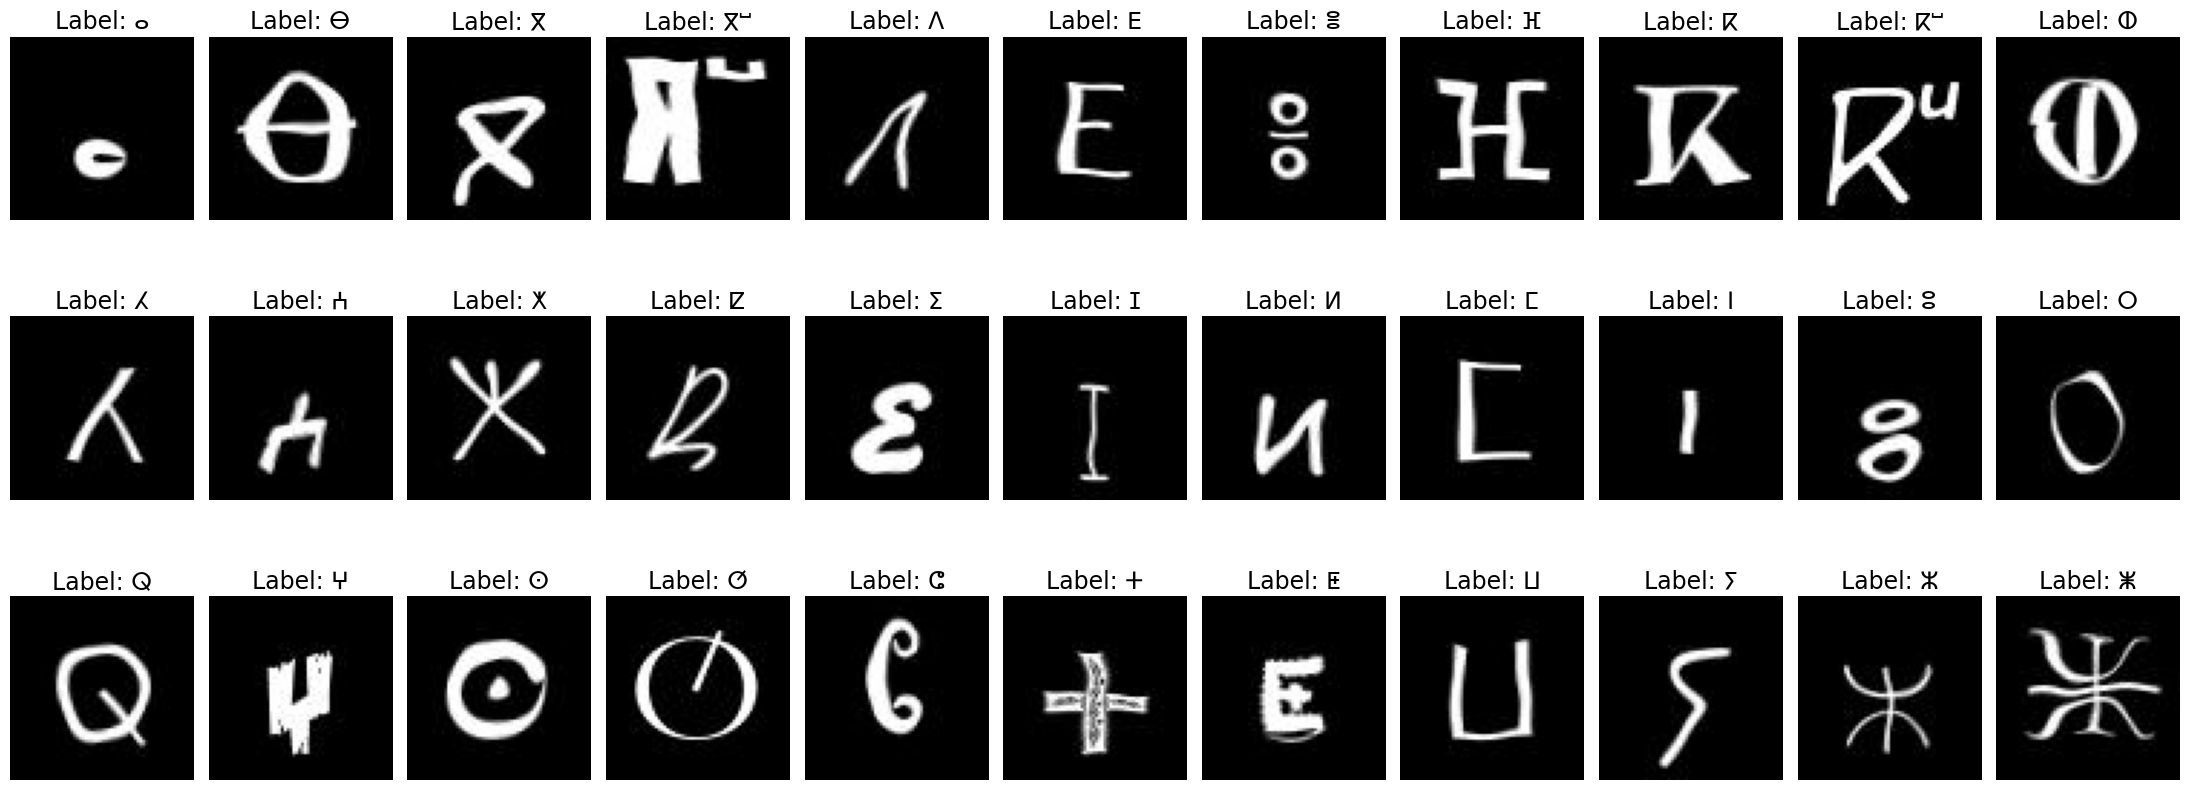

In [ ]:
fig = display_sample_images_from_paths(labels_df, data_dir)
plt.savefig('sample_images.png')
files.download('sample_images.png')
# plt.close()


In [ ]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.reshape(-1, 1))
print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Train: 16908, Val: 5637, Test: 5637


# **8.Hyperparameter Tuning**


In [ ]:
layer_sizes = [32 * 32, 64, 32, num_classes]
param_distributions = {
    'learning_rate': [0.01, 0.001],
    'l2_lambda': [0.01, 0.001],
    'batch_size': [64, 32],
    'optimizer': ['adam', 'sgd']
}
n_iter = 16
results = []
best_val_accuracy = 0
best_params = None


In [ ]:
# ===================== Random Search + CV Loop =======================

for i in range(n_iter):
    params = {k: random.choice(v) for k, v in param_distributions.items()}
    print(f"\nTrial {i + 1}/{n_iter}: {params}")
    avg_train_losses, avg_val_losses, avg_train_accuracies, avg_val_accuracies = k_fold_cross_validation(
        X_train, y_train_one_hot, layer_sizes, k=5, epochs=100, **params, augment=True, verbose=1
    )
    final_val_accuracy = avg_val_accuracies[-1]
    results.append({'trial': i + 1, 'params': params, 'final_val_accuracy': final_val_accuracy})
    if final_val_accuracy > best_val_accuracy:
        best_val_accuracy = final_val_accuracy
        best_params = params

print(f"\nBest parameters: {best_params}")
print(f"Best validation accuracy: {best_val_accuracy:.4f}")


In [ ]:
# ========== Save best parameters and best validation accuracy + layer_sizes ==========
with open("random_search_results.json", "w") as f:
    json.dump({
        "best_params": best_params,
        "best_val_accuracy": best_val_accuracy,
        "layer_sizes": layer_sizes
    }, f)

files.download('random_search_results.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Best parameters and accuracy saved to random_search_results.json


## **9.Perform k-fold cross-validation with SGD & Adam**


In [ ]:
# =================== Load saved random_search_results.json file ================
with open("random_search_results.json", "r") as f:
    data = json.load(f)
    best_params = data["best_params"]
    layer_sizes = data["layer_sizes"]
    best_val_accuracy = data["best_val_accuracy"]

learning_rate = best_params['learning_rate']
l2_lambda = best_params['l2_lambda']
batch_size = best_params['batch_size']
optimizer = best_params['optimizer']

### **9.1.Perform k-fold cross-validation with SGD**

In [ ]:
print("\nK-Fold Cross-Validation with SGD (Augmented):")
avg_train_losses_sgd, avg_val_losses_sgd, avg_train_accuracies_sgd, avg_val_accuracies_sgd = k_fold_cross_validation(
    X_train, y_train_one_hot, layer_sizes, k=5, epochs=100, batch_size=batch_size, learning_rate=learning_rate, l2_lambda=l2_lambda, optimizer='sgd', augment=True
)


K-Fold Cross-Validation with SGD (Augmented):

Fold 1/5
Epoch 001 | Train Loss: 3.5257 | Val Loss: 3.5096 | Train Acc: 0.0312 | Val Acc: 0.0322
Epoch 011 | Train Loss: 3.3961 | Val Loss: 3.3487 | Train Acc: 0.0848 | Val Acc: 0.0804
Epoch 021 | Train Loss: 3.2496 | Val Loss: 3.1488 | Train Acc: 0.1394 | Val Acc: 0.1263
Epoch 031 | Train Loss: 3.0943 | Val Loss: 2.9283 | Train Acc: 0.1898 | Val Acc: 0.1818
Epoch 041 | Train Loss: 2.9472 | Val Loss: 2.7098 | Train Acc: 0.2523 | Val Acc: 0.2428
Epoch 051 | Train Loss: 2.7873 | Val Loss: 2.5105 | Train Acc: 0.3097 | Val Acc: 0.2948
Epoch 061 | Train Loss: 2.6659 | Val Loss: 2.3492 | Train Acc: 0.3557 | Val Acc: 0.3374
Epoch 071 | Train Loss: 2.5496 | Val Loss: 2.2194 | Train Acc: 0.3874 | Val Acc: 0.3658
Epoch 081 | Train Loss: 2.4567 | Val Loss: 2.1102 | Train Acc: 0.4091 | Val Acc: 0.3856
Epoch 091 | Train Loss: 2.3524 | Val Loss: 2.0153 | Train Acc: 0.4343 | Val Acc: 0.4098
Epoch 100 | Train Loss: 2.2764 | Val Loss: 1.9377 | Train Acc: 

### **9.2.Perform k-fold cross-validation with Adam**

In [ ]:
print("\nK-Fold Cross-Validation with Adam (Augmented):")
avg_train_losses_adam, avg_val_losses_adam, avg_train_accuracies_adam, avg_val_accuracies_adam = k_fold_cross_validation(
    X_train, y_train_one_hot, layer_sizes, k=5, epochs=100, batch_size=batch_size, learning_rate=learning_rate, l2_lambda=l2_lambda, optimizer='adam', augment=True
)


K-Fold Cross-Validation with Adam (Augmented):

Fold 1/5
Epoch 001 | Train Loss: 2.9324 | Val Loss: 2.1683 | Train Acc: 0.4083 | Val Acc: 0.3823
Epoch 011 | Train Loss: 1.2396 | Val Loss: 0.9687 | Train Acc: 0.7133 | Val Acc: 0.6892
Epoch 021 | Train Loss: 1.0223 | Val Loss: 0.7761 | Train Acc: 0.7730 | Val Acc: 0.7507
Epoch 031 | Train Loss: 0.9056 | Val Loss: 0.6797 | Train Acc: 0.7921 | Val Acc: 0.7830
Epoch 041 | Train Loss: 0.8357 | Val Loss: 0.6975 | Train Acc: 0.7978 | Val Acc: 0.7803
Epoch 051 | Train Loss: 0.7965 | Val Loss: 0.6312 | Train Acc: 0.8091 | Val Acc: 0.7921
Epoch 061 | Train Loss: 0.7593 | Val Loss: 0.5799 | Train Acc: 0.8297 | Val Acc: 0.8176
Epoch 071 | Train Loss: 0.7182 | Val Loss: 0.5568 | Train Acc: 0.8399 | Val Acc: 0.8220
Epoch 081 | Train Loss: 0.7215 | Val Loss: 0.5429 | Train Acc: 0.8469 | Val Acc: 0.8205
Epoch 091 | Train Loss: 0.6807 | Val Loss: 0.5071 | Train Acc: 0.8527 | Val Acc: 0.8412
Epoch 100 | Train Loss: 0.6713 | Val Loss: 0.5493 | Train Acc:

### **9.3.Ploting k-fold cross-validation results (with SGD & Adam)**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

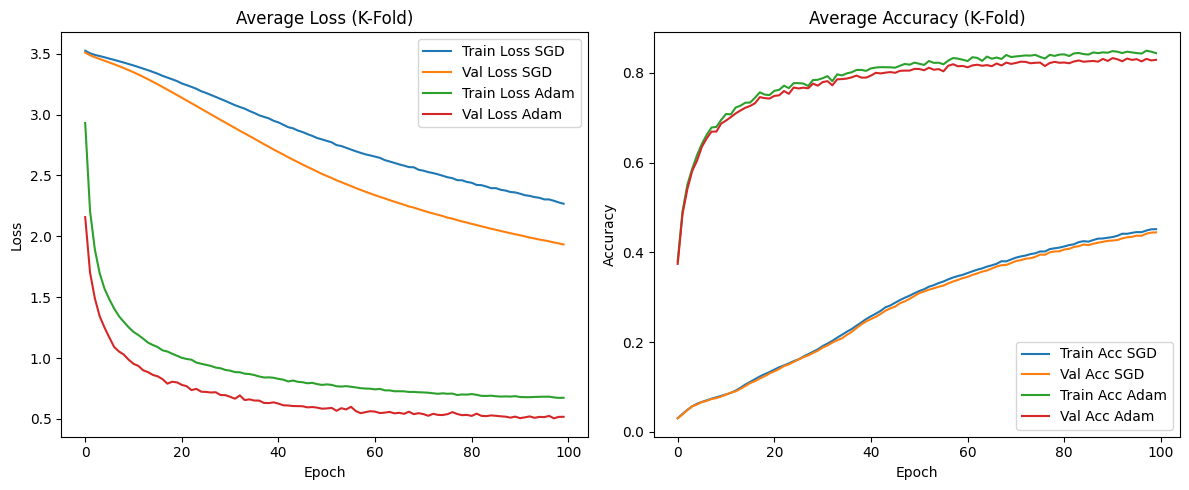

In [ ]:
# Plot Cross-Validation Results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(avg_train_losses_sgd, label='Train Loss SGD')
ax1.plot(avg_val_losses_sgd, label='Val Loss SGD')
ax1.plot(avg_train_losses_adam, label='Train Loss Adam')
ax1.plot(avg_val_losses_adam, label='Val Loss Adam')
ax1.set_title('Average Loss (K-Fold)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(avg_train_accuracies_sgd, label='Train Acc SGD')
ax2.plot(avg_val_accuracies_sgd, label='Val Acc SGD')
ax2.plot(avg_train_accuracies_adam, label='Train Acc Adam')
ax2.plot(avg_val_accuracies_adam, label='Val Acc Adam')
ax2.set_title('Average Accuracy (K-Fold)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('kfold_loss_accuracy_sgd_adam.png')
files.download('kfold_loss_accuracy_sgd_adam.png')
# plt.close()

## **10.Train final model with Best parameters on full train+val set:**

In [ ]:
# =================== Load saved random_search_results.json file ================
with open("random_search_results.json", "r") as f:
    data = json.load(f)
    best_params = data["best_params"]
    layer_sizes = data["layer_sizes"]
    best_val_accuracy = data["best_val_accuracy"]

learning_rate = best_params['learning_rate']
l2_lambda = best_params['l2_lambda']
batch_size = best_params['batch_size']
optimizer = best_params['optimizer']

# 10. Final Model Training and Evaluation
*  Train models on combined train+val set, evaluate on test set, with and without augmentation.
*  Note: We combine `X_train` and `X_val` into `X_train_val` to maximize training data (~ 20,290 samples) for the final model,after hyperparameter tuning. A new 10% validation set is split from `X_train_val` for early stopping to avoid using `X_test`.

In [ ]:
X_train_val = np.concatenate([X_train, X_val])
y_train_val_one_hot = np.concatenate([y_train_one_hot, y_val_one_hot])

# Split a new validation set from X_train_val
X_train_final, X_val_final, y_train_final_one_hot, y_val_final_one_hot = train_test_split(
    X_train_val, y_train_val_one_hot, test_size=0.1, stratify=np.argmax(y_train_val_one_hot, axis=1), random_state=42
)
print(f"Final Train: {X_train_final.shape[0]}, Final Val: {X_val_final.shape[0]}, Test: {X_test.shape[0]}")


Final Train: 20290, Final Val: 2255, Test: 5637


### **Case 1:  No Augmentation**

In [ ]:
# Case 1: No Augmentation
nn = MulticlassNeuralNetwork(layer_sizes, learning_rate=best_params['learning_rate'],
                             l2_lambda=best_params['l2_lambda'], optimizer=best_params['optimizer'])
train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
    X_train_final, y_train_final_one_hot, X_val_final, y_val_final_one_hot, epochs=100,
    batch_size=best_params['batch_size'], augment=False, early_stopping=True
)


Epoch 001 | Train Loss: 1.9251 | Val Loss: 1.2002 | Train Acc: 0.6679 | Val Acc: 0.6559
Epoch 011 | Train Loss: 0.1977 | Val Loss: 0.3198 | Train Acc: 0.9511 | Val Acc: 0.9007
Epoch 021 | Train Loss: 0.1008 | Val Loss: 0.2676 | Train Acc: 0.9828 | Val Acc: 0.9259
Epoch 031 | Train Loss: 0.0828 | Val Loss: 0.2429 | Train Acc: 0.9935 | Val Acc: 0.9322
Early stopping at epoch 32


In [ ]:
y_pred = nn.predict(X_test)
print("\nTest Set Classification Report (No Augmentation):")
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred, target_names=label_encoder.classes_))

test_accuracy = np.mean(y_pred == np.argmax(y_test_one_hot, axis=1))
print(f"Test Accuracy (No Augmentation): {test_accuracy:.4f}")


Test Set Classification Report (No Augmentation):
              precision    recall  f1-score   support

           ⴰ       0.93      0.97      0.95       171
           ⴱ       0.82      0.85      0.83       171
           ⴳ       0.95      0.94      0.94       171
          ⴳⵯ       0.97      0.97      0.97       171
           ⴷ       0.93      0.97      0.95       171
           ⴹ       0.81      0.81      0.81       171
           ⴻ       0.89      0.87      0.88       171
           ⴼ       0.96      0.96      0.96       171
           ⴽ       0.92      0.94      0.93       170
          ⴽⵯ       0.96      0.96      0.96       170
           ⵀ       0.95      0.94      0.94       171
           ⵃ       0.97      0.94      0.95       171
           ⵄ       0.98      0.96      0.97       171
           ⵅ       0.92      0.98      0.95       171
           ⵇ       0.93      0.95      0.94       171
           ⵉ       0.88      0.87      0.88       170
           ⵊ       0.91      0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

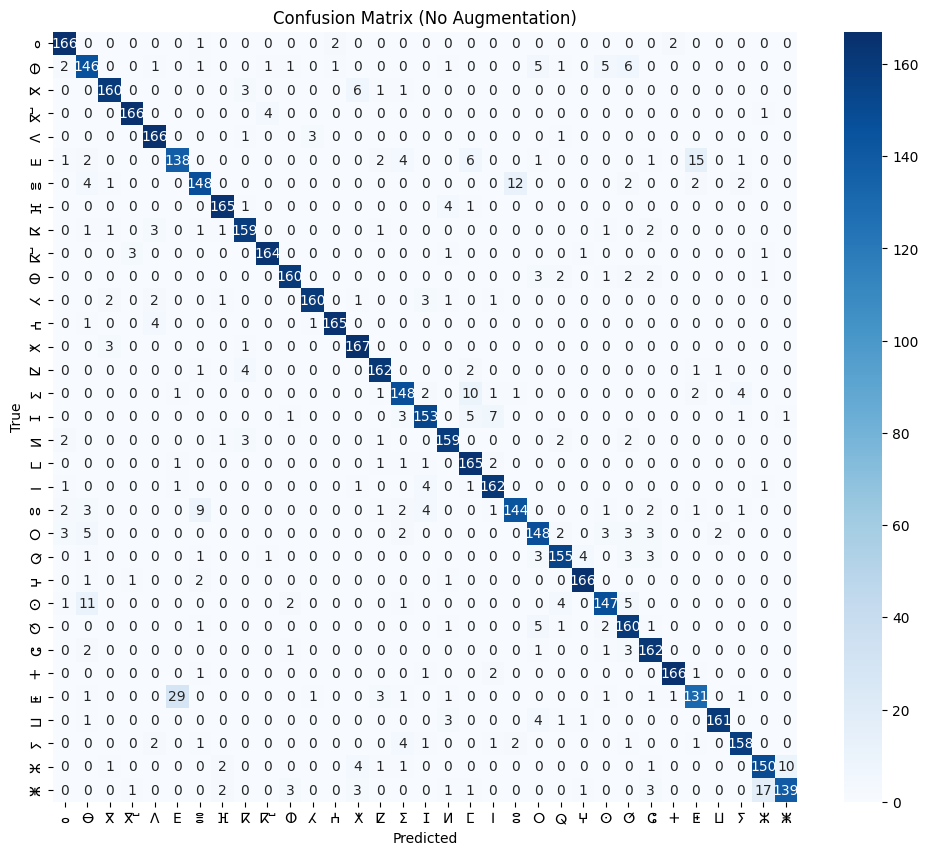

In [ ]:
cm = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (No Augmentation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_no_aug.png')
files.download('confusion_matrix_no_aug.png')
# plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

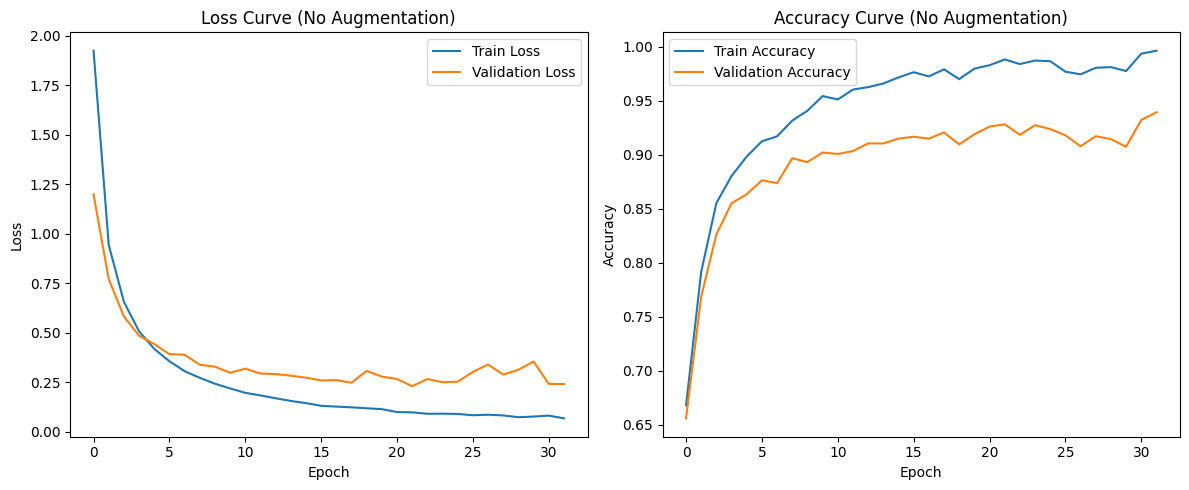

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title('Loss Curve (No Augmentation)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title('Accuracy Curve (No Augmentation)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_no_aug.png')
files.download('loss_accuracy_no_aug.png')
# plt.close()


### **Case 2:  With Augmentation**

In [ ]:
# Case 2: With Augmentation
nn_aug = MulticlassNeuralNetwork(layer_sizes, learning_rate=best_params['learning_rate'],
                                 l2_lambda=best_params['l2_lambda'], optimizer=best_params['optimizer'])
train_losses_aug, val_losses_aug, train_accuracies_aug, val_accuracies_aug = nn_aug.train(
    X_train_final, y_train_final_one_hot, X_val_final, y_val_final_one_hot, epochs=100,
    batch_size=best_params['batch_size'], augment=True, early_stopping=True
)


Epoch 001 | Train Loss: 2.7366 | Val Loss: 1.8759 | Train Acc: 0.4214 | Val Acc: 0.4164
Epoch 011 | Train Loss: 1.0963 | Val Loss: 0.7848 | Train Acc: 0.7357 | Val Acc: 0.7450
Epoch 021 | Train Loss: 0.9020 | Val Loss: 0.6455 | Train Acc: 0.7759 | Val Acc: 0.7787
Epoch 031 | Train Loss: 0.8131 | Val Loss: 0.5497 | Train Acc: 0.8171 | Val Acc: 0.8177
Epoch 041 | Train Loss: 0.7463 | Val Loss: 0.5199 | Train Acc: 0.8178 | Val Acc: 0.8284
Epoch 051 | Train Loss: 0.6986 | Val Loss: 0.4897 | Train Acc: 0.8377 | Val Acc: 0.8435
Epoch 061 | Train Loss: 0.6737 | Val Loss: 0.4327 | Train Acc: 0.8586 | Val Acc: 0.8532
Epoch 071 | Train Loss: 0.6498 | Val Loss: 0.4307 | Train Acc: 0.8580 | Val Acc: 0.8519
Epoch 081 | Train Loss: 0.6408 | Val Loss: 0.4299 | Train Acc: 0.8600 | Val Acc: 0.8523
Early stopping at epoch 83


In [ ]:
y_pred_aug = nn_aug.predict(X_test)
print("\nTest Set Classification Report (With Augmentation):")
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred_aug, target_names=label_encoder.classes_))

test_accuracy_aug = np.mean(y_pred_aug == np.argmax(y_test_one_hot, axis=1))
print(f"Test Accuracy (With Augmentation): {test_accuracy_aug:.4f}")


Test Set Classification Report (With Augmentation):
              precision    recall  f1-score   support

           ⴰ       0.93      0.91      0.92       171
           ⴱ       0.76      0.77      0.76       171
           ⴳ       0.86      0.93      0.90       171
          ⴳⵯ       0.93      0.91      0.92       171
           ⴷ       0.90      0.95      0.92       171
           ⴹ       0.61      0.84      0.70       171
           ⴻ       0.87      0.72      0.79       171
           ⴼ       0.87      0.89      0.88       171
           ⴽ       0.84      0.96      0.90       170
          ⴽⵯ       0.91      0.95      0.93       170
           ⵀ       0.89      0.90      0.89       171
           ⵃ       0.87      0.99      0.93       171
           ⵄ       0.97      0.89      0.93       171
           ⵅ       0.92      0.82      0.87       171
           ⵇ       0.94      0.80      0.87       171
           ⵉ       0.84      0.66      0.74       170
           ⵊ       0.77     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

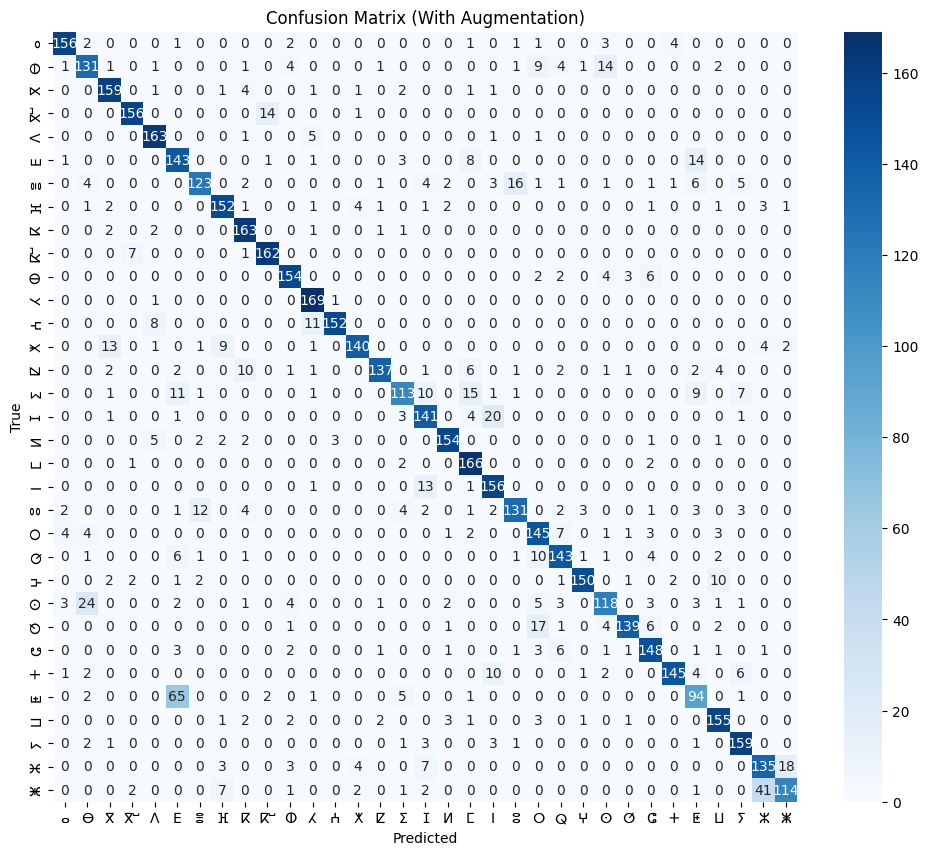

In [ ]:
cm_aug = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred_aug)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (With Augmentation)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_with_aug.png')
files.download('confusion_matrix_with_aug.png')
# plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

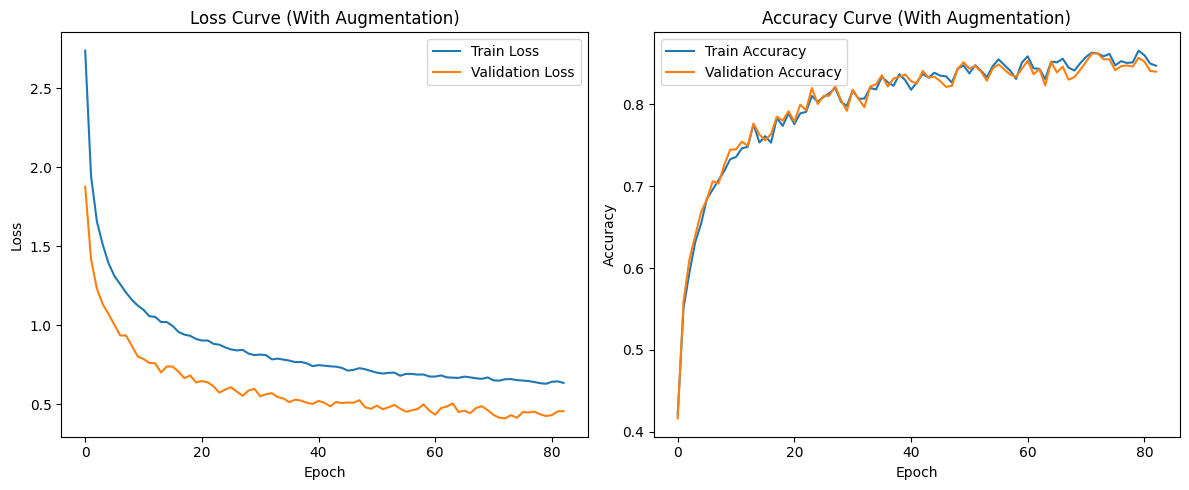

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses_aug, label='Train Loss')
ax1.plot(val_losses_aug, label='Validation Loss')
ax1.set_title('Loss Curve (With Augmentation)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies_aug, label='Train Accuracy')
ax2.plot(val_accuracies_aug, label='Validation Accuracy')
ax2.set_title('Accuracy Curve (With Augmentation)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_with_aug.png')
files.download('loss_accuracy_with_aug.png')
# plt.close()


## **11.Alternative: Train on X_train only, use X_val for early stopping**
This section trains the model on `X_train` (~ 16,934 samples) with `X_val` (~ 5,645 samples) for early stopping to compare against the main approach (`X_train_val` with a 10% validation split).

### **Case 1:  No Augmentation (Alternative)**

In [ ]:
# Case 1: No Augmentation (Alternative)
nn_alt = MulticlassNeuralNetwork(layer_sizes, learning_rate=best_params['learning_rate'],
                                 l2_lambda=best_params['l2_lambda'], optimizer=best_params['optimizer'])
train_losses_alt, val_losses_alt, train_accuracies_alt, val_accuracies_alt = nn_alt.train(
    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=100,
    batch_size=best_params['batch_size'], augment=False, early_stopping=True
)


Epoch 001 | Train Loss: 2.0403 | Val Loss: 1.2738 | Train Acc: 0.6605 | Val Acc: 0.6291
Epoch 011 | Train Loss: 0.2183 | Val Loss: 0.3503 | Train Acc: 0.9527 | Val Acc: 0.8943
Epoch 021 | Train Loss: 0.1118 | Val Loss: 0.3277 | Train Acc: 0.9795 | Val Acc: 0.9017
Epoch 031 | Train Loss: 0.0739 | Val Loss: 0.3038 | Train Acc: 0.9930 | Val Acc: 0.9163
Early stopping at epoch 33


In [ ]:
y_pred_alt = nn_alt.predict(X_test)
print("\nTest Set Classification Report (No Augmentation, Alternative):")
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred_alt, target_names=label_encoder.classes_))

test_accuracy_alt = np.mean(y_pred_alt == np.argmax(y_test_one_hot, axis=1))
print(f"Test Accuracy (No Augmentation, Alternative): {test_accuracy_alt:.4f}")



Test Set Classification Report (No Augmentation, Alternative):
              precision    recall  f1-score   support

           ⴰ       0.92      0.94      0.93       171
           ⴱ       0.82      0.77      0.80       171
           ⴳ       0.96      0.90      0.93       171
          ⴳⵯ       0.98      0.98      0.98       171
           ⴷ       0.98      0.92      0.95       171
           ⴹ       0.75      0.87      0.80       171
           ⴻ       0.91      0.80      0.85       171
           ⴼ       0.93      0.96      0.95       171
           ⴽ       0.92      0.95      0.93       170
          ⴽⵯ       0.96      0.96      0.96       170
           ⵀ       0.84      0.95      0.89       171
           ⵃ       0.97      0.92      0.95       171
           ⵄ       0.94      0.99      0.97       171
           ⵅ       0.95      0.95      0.95       171
           ⵇ       0.94      0.92      0.93       171
           ⵉ       0.91      0.92      0.92       170
           ⵊ     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

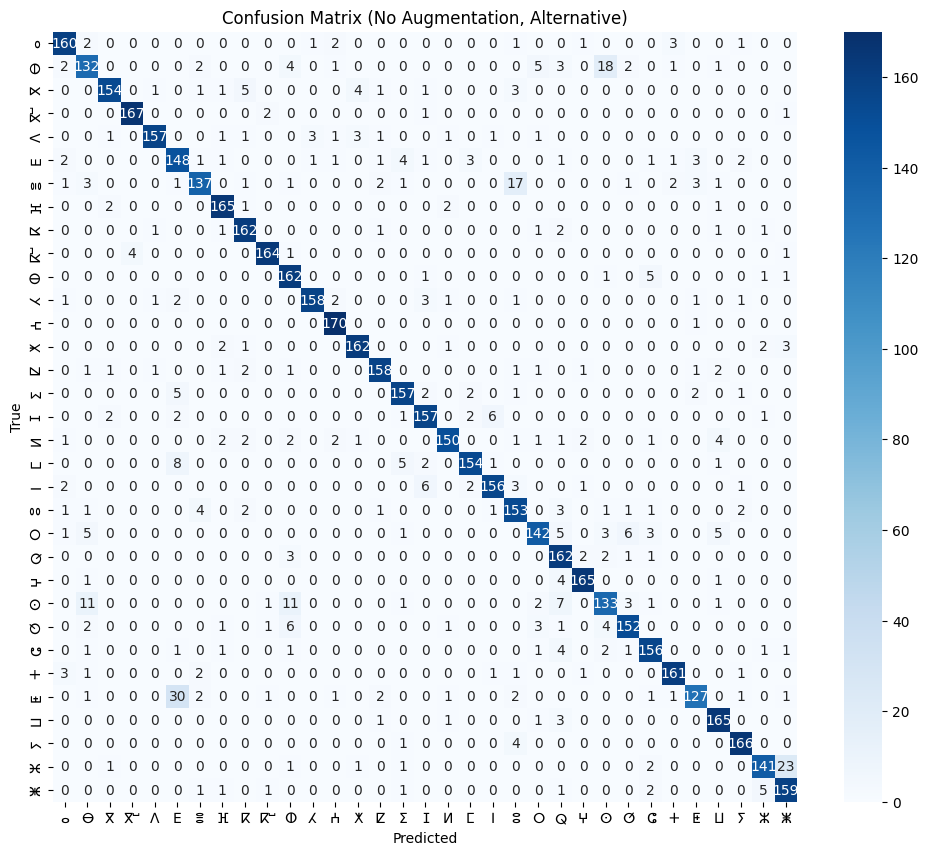

In [ ]:
cm_alt = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred_alt)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_alt, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (No Augmentation, Alternative)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_no_aug_alt.png')
files.download('confusion_matrix_no_aug_alt.png')
# plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

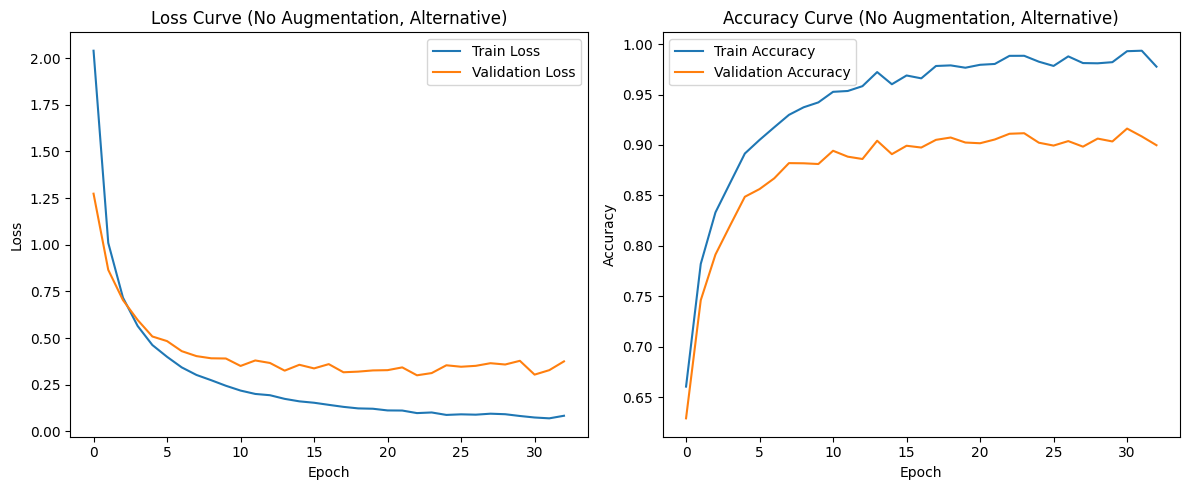

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses_alt, label='Train Loss')
ax1.plot(val_losses_alt, label='Validation Loss')
ax1.set_title('Loss Curve (No Augmentation, Alternative)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies_alt, label='Train Accuracy')
ax2.plot(val_accuracies_alt, label='Validation Accuracy')
ax2.set_title('Accuracy Curve (No Augmentation, Alternative)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_no_aug_alt.png')
files.download('loss_accuracy_no_aug_alt.png')
# plt.close()


### **Case 2:  With Augmentation (Alternative)**

In [ ]:
# Case 2: With Augmentation (Alternative)
nn_aug_alt = MulticlassNeuralNetwork(layer_sizes, learning_rate=best_params['learning_rate'],
                                     l2_lambda=best_params['l2_lambda'], optimizer=best_params['optimizer'])
train_losses_aug_alt, val_losses_aug_alt, train_accuracies_aug_alt, val_accuracies_aug_alt = nn_aug_alt.train(
    X_train, y_train_one_hot, X_val, y_val_one_hot, epochs=100,
    batch_size=best_params['batch_size'], augment=True, early_stopping=True
)


Epoch 001 | Train Loss: 2.8113 | Val Loss: 2.0005 | Train Acc: 0.4410 | Val Acc: 0.4305
Epoch 011 | Train Loss: 1.1272 | Val Loss: 0.8969 | Train Acc: 0.7183 | Val Acc: 0.7137
Epoch 021 | Train Loss: 0.9390 | Val Loss: 0.7218 | Train Acc: 0.7770 | Val Acc: 0.7674
Epoch 031 | Train Loss: 0.8262 | Val Loss: 0.6336 | Train Acc: 0.8048 | Val Acc: 0.7974
Epoch 041 | Train Loss: 0.7841 | Val Loss: 0.6032 | Train Acc: 0.8198 | Val Acc: 0.8049
Epoch 051 | Train Loss: 0.7349 | Val Loss: 0.5778 | Train Acc: 0.8196 | Val Acc: 0.8017
Epoch 061 | Train Loss: 0.7042 | Val Loss: 0.5214 | Train Acc: 0.8378 | Val Acc: 0.8254
Epoch 071 | Train Loss: 0.6943 | Val Loss: 0.5589 | Train Acc: 0.8330 | Val Acc: 0.8155
Epoch 081 | Train Loss: 0.6562 | Val Loss: 0.5056 | Train Acc: 0.8403 | Val Acc: 0.8301
Epoch 091 | Train Loss: 0.6459 | Val Loss: 0.5323 | Train Acc: 0.8348 | Val Acc: 0.8214
Epoch 100 | Train Loss: 0.6201 | Val Loss: 0.4768 | Train Acc: 0.8511 | Val Acc: 0.8398


In [ ]:
y_pred_aug_alt = nn_aug_alt.predict(X_test)
print("\nTest Set Classification Report (With Augmentation, Alternative):")
print(classification_report(np.argmax(y_test_one_hot, axis=1), y_pred_aug_alt, target_names=label_encoder.classes_))

test_accuracy_aug_alt = np.mean(y_pred_aug_alt == np.argmax(y_test_one_hot, axis=1))
print(f"Test Accuracy (With Augmentation, Alternative): {test_accuracy_aug_alt:.4f}")



Test Set Classification Report (With Augmentation, Alternative):
              precision    recall  f1-score   support

           ⴰ       0.85      0.98      0.91       171
           ⴱ       0.53      0.80      0.64       171
           ⴳ       0.91      0.91      0.91       171
          ⴳⵯ       0.91      0.96      0.93       171
           ⴷ       0.93      0.91      0.92       171
           ⴹ       0.60      0.84      0.70       171
           ⴻ       0.74      0.70      0.72       171
           ⴼ       0.93      0.91      0.92       171
           ⴽ       0.88      0.91      0.89       170
          ⴽⵯ       0.91      0.88      0.90       170
           ⵀ       0.97      0.80      0.87       171
           ⵃ       0.93      0.98      0.95       171
           ⵄ       0.93      0.89      0.91       171
           ⵅ       0.92      0.89      0.91       171
           ⵇ       0.82      0.84      0.83       171
           ⵉ       0.86      0.73      0.79       170
           ⵊ   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

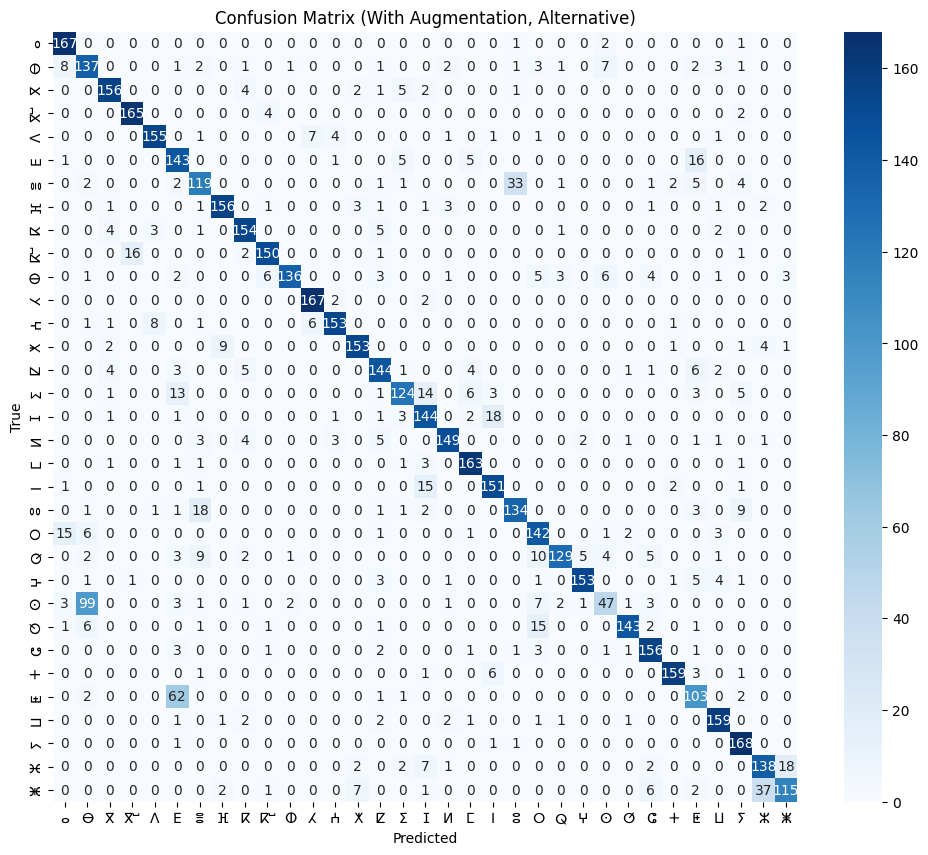

In [ ]:
cm_aug_alt = confusion_matrix(np.argmax(y_test_one_hot, axis=1), y_pred_aug_alt)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_aug_alt, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (With Augmentation, Alternative)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_with_aug_alt.png')
files.download('confusion_matrix_with_aug_alt.png')
# plt.close()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

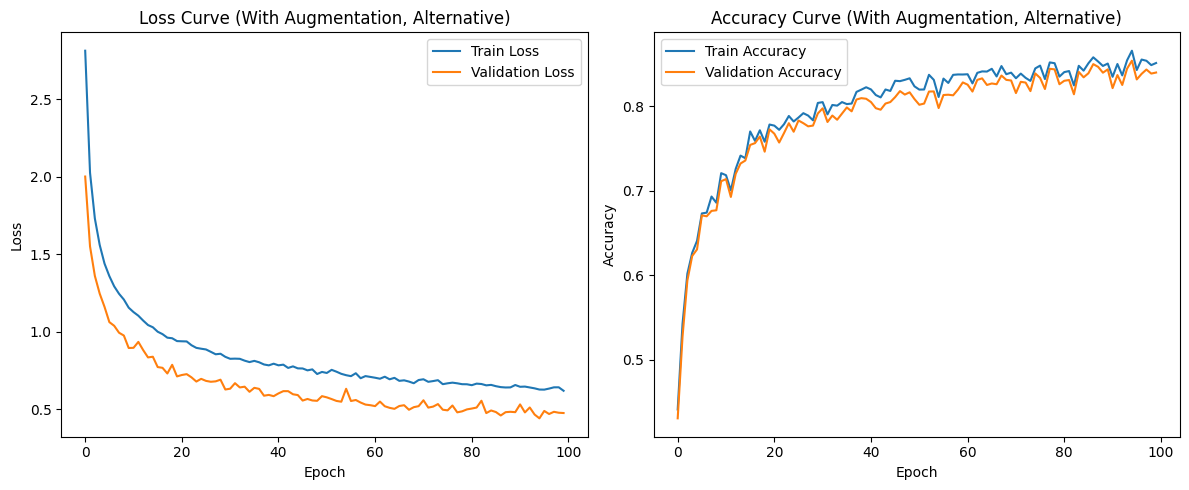

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses_aug_alt, label='Train Loss')
ax1.plot(val_losses_aug_alt, label='Validation Loss')
ax1.set_title('Loss Curve (With Augmentation, Alternative)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_accuracies_aug_alt, label='Train Accuracy')
ax2.plot(val_accuracies_aug_alt, label='Validation Accuracy')
ax2.set_title('Accuracy Curve (With Augmentation, Alternative)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.tight_layout()
plt.savefig('loss_accuracy_with_aug_alt.png')
files.download('loss_accuracy_with_aug_alt.png')
# plt.close()


In [ ]:
comparison_results = {
    'main_no_aug': test_accuracy,
    'main_with_aug': test_accuracy_aug,
    'alt_no_aug': test_accuracy_alt,
    'alt_with_aug': test_accuracy_aug_alt
}
with open('comparison_results.json', 'w') as f:
    json.dump(comparison_results, f)
files.download('comparison_results.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

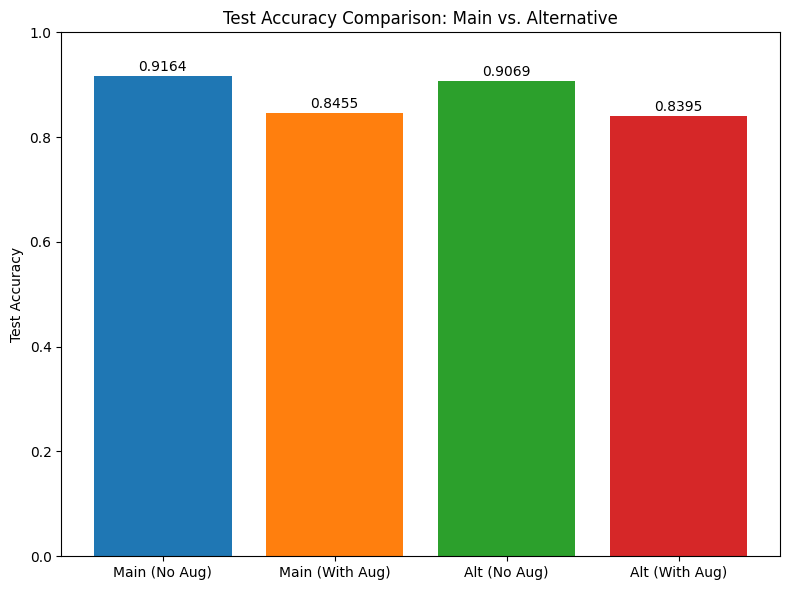

In [ ]:
# Comparison Bar Chart
fig, ax = plt.subplots(figsize=(8, 6))
approaches = ['Main (No Aug)', 'Main (With Aug)', 'Alt (No Aug)', 'Alt (With Aug)']
accuracies = [test_accuracy, test_accuracy_aug, test_accuracy_alt, test_accuracy_aug_alt]
ax.bar(approaches, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_title('Test Accuracy Comparison: Main vs. Alternative')
ax.set_ylabel('Test Accuracy')
ax.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.tight_layout()
plt.savefig('test_accuracy_comparison.png')
files.download('test_accuracy_comparison.png')
# plt.close()

## **12. Results Summary**
- Best parameters: {'learning_rate': 0.001, 'l2_lambda': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
- Best validation accuracy: 82.93%
- **Main Approach**:
  - Test accuracy (No Augmentation): 91.64%
  - Test accuracy (With Augmentation): 84.55%
- **Alternative Approach**:
  - Test accuracy (No Augmentation): 90.69%
  - Test accuracy (With Augmentation): 83.95%
- Figure: Test accuracy comparison (`test_accuracy_comparison.png`)